In [239]:
%matplotlib notebook
import numpy as np
from colicoords import load, save, Data, filter_binaries, data_to_cells, CellPlot, CellListPlot, CellList, IterCellPlot, iter_subplots
import matplotlib.pyplot as plt
import tifffile
import mahotas as mh
import re
import pickle
from tqdm.auto import tqdm

In [26]:
def chunk_list(l, sizes):
    prev = 0
    for s in sizes:
        result = l[prev:prev+s]
        prev += s
        yield result


def encode(cell, name):
    xs = np.clip(np.round(cell.data.data_dict[name]['x']).astype(int), 0, cell.data.shape[1] - 1)
    ys = np.clip(np.round(cell.data.data_dict[name]['y']).astype(int), 0, cell.data.shape[0] - 1)
    intensity = cell.data.data_dict[name]['intensity']
    pixels = cell.data.binary_img[ys, xs].astype(bool)

    encode_arr = (200 * np.arange(len(intensity[pixels])) + 1) ** 2
    return np.sum(intensity[pixels] * encode_arr)


def encode_intensity(cells):
    out_arr = np.empty(len(cells))
    for i, cell in enumerate(cells):
        s1 = encode(cell, 'storm_outer')
        s2 = encode(cell, 'storm_inner')

        out_arr[i] = s1 + s2

    return out_arr


def match_cells(gt_cells, m_cells):
        """Iterate though measured cells m_cells and tries to find corresponding cell in ground-truth cells"""
        gt_out, m_out = [], []
        f_out = []
        f1_out = []
        s_100_gt = []
        s_100_m = []

        # storm_int_gt = encode_intensity(gt_cells)
        # assert len(storm_int_gt) == len(np.unique(storm_int_gt))
        storm_int_gt = np.load('encoded.npy')
        st = np.load('storm_int.npy')
        img_number = np.load('img_number.npy')


        storm_int_m = encode_intensity(m_cells)
        zeros = storm_int_m == 0  # cells with zero intensity are false positive
        assert len(storm_int_m[~zeros]) == len(np.unique(storm_int_m[~zeros]))
        print('bools total', np.sum([zeros]))

        n = 0
        j = 0
        for k, (cell, int_val) in enumerate(zip(m_cells[~zeros], storm_int_m[~zeros])):
            try:
                i = list(storm_int_gt).index(int_val)
                #gt_out.append(gt_cells[i])
                m_out.append(cell)
            except ValueError:
                n += 1
                f_out.append(cell)

                c_n = int(re.findall(r'(\d+)', cell.name)[0])
                b = img_number == c_n

                st_c = cell.data.data_dict['storm_outer']['intensity']
                sums = [np.sum([elem in st_elem for elem in st_c]) for st_elem in st[b]]
                if sums and np.max(sums) > 100:
                    i = np.argmax(sums)
                    s_100_gt.append(gt_cells[b][i])
                    s_100_m.append(cell)
                    #gt_out.append(gt_cells[b][i])
                else:
                    f1_out.append(cell)
                    print('cell number', c_n)
                    print(np.sum(b))
                    print('sums', sums)

                    j += 1


                continue

        print('Identified {} cells, not found {} out of total {}'.format(len(gt_out), n, len(m_cells)))
        print("j", j)

        return gt_out, m_out, f_out, f1_out, s_100_gt, s_100_m


def match_all():
    print('Loading GT')
    #gt_cells = load('cells_final_selected.hdf5')
    for ph in [500]:
        print(f'Photons {ph}')

        m_cells = load('cell_obj/cell_ph_{}_raw.hdf5'.format(ph))
        print('Measured cells loaded')

        gt_match, m_match, failed, f1 = match_cells(m_cells)
        # save('cell_obj/gt_cells_ph_{}_match_raw.hdf5'.format(ph), CellList(gt_match))
        # save('cell_obj/m_cells_ph_{}_match_raw.hdf5'.format(ph), CellList(m_match))
        save('cell_obj/m_cells_ph_{}_fail_raw.hdf5'.format(ph), CellList(failed))
        save('cell_obj/m_cells_ph_{}_fail1_raw.hdf5'.format(ph), CellList(f1))


In [4]:
gt_cells = load('cells_final_selected.hdf5')

In [11]:
m_cells = load('cell_obj/cell_ph_500_raw.hdf5')

In [6]:
with open('temp_cell.pick', 'wb') as f:
    pickle.dump(gt_cells, f)

In [15]:
f1_cells = load('cell_obj/m_cells_ph_500_fail1_raw.hdf5')

In [18]:
len(f1_cells)

12

<IPython.core.display.Javascript object>


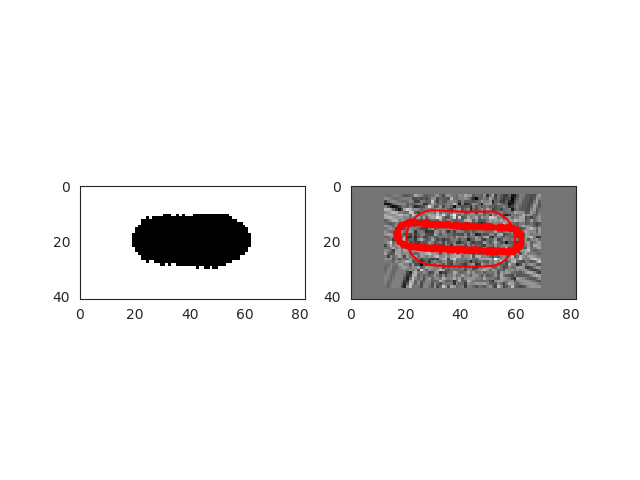

In [23]:
cp = IterCellPlot(f1_cells)
fig, axes = iter_subplots(1, 2)
cp.imshow('binary', ax=axes[0])
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])
cp.plot_storm(data_name='storm_inner')
fig.display()

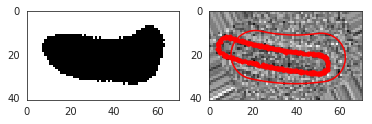

In [17]:
cp = CellPlot(f1_cells[0])
fig, axes = plt.subplots(1, 2)
cp.imshow('binary', ax=axes[0])
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])
cp.plot_storm(data_name='storm_inner')

In [13]:
61.69625811 % 1

0.6962581100000023

In [10]:
match_cells(m_cells)

STORMTable([(61.69625811, 24.90487934, 0, 158),
            (45.17857653, 35.39667132, 0, 212),
            (46.56703636, 23.3437708 , 0, 141),
            (23.87490561, 30.28025346, 0,  50),
            (26.92846979, 24.58465204, 0, 175),
            (27.05697131, 24.63709691, 0, 350),
            (56.12383698, 36.09177284, 0, 213),
            (41.46497707, 23.51364685, 0,  91),
            (30.64342201, 23.99791551, 0, 208),
            (63.61840497, 29.61551401, 0, 257),
            (28.64065579, 35.59670537, 0, 243),
            (37.42812821, 35.45853797, 0, 178),
            (54.36206304, 35.51233261, 0, 241),
            (52.69328087, 35.59265581, 0, 258),
            (47.56312906, 23.72552286, 0, 196),
            (42.86468045, 35.03421792, 0, 115),
            (31.68466284, 23.73382304, 0, 160),
            (62.86998095, 33.12767227, 0, 315),
            (34.45756222, 35.61021345, 0, 215),
            (51.85149375, 23.37694152, 0, 205),
            (33.8005067 , 23.71645738, 0

In [ ]:

img_number = np.array([int(re.findall(r'(\d+)', c.name)[0]) for c in gt_cells])

In [27]:
gt_out, m_out, f_out, f1_out, s_100_gt, s_100_m = match_cells(gt_cells, m_cells)

bools total 61
cell number 206
0
sums []
cell number 206
0
sums []
cell number 206
0
sums []
cell number 617
0
sums []
cell number 617
0
sums []
cell number 617
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
cell number 873
0
sums []
Identified 0 cells, not found 1540 out of total 6827
j 12


In [28]:
len(s_100_gt)

1528

<IPython.core.display.Javascript object>


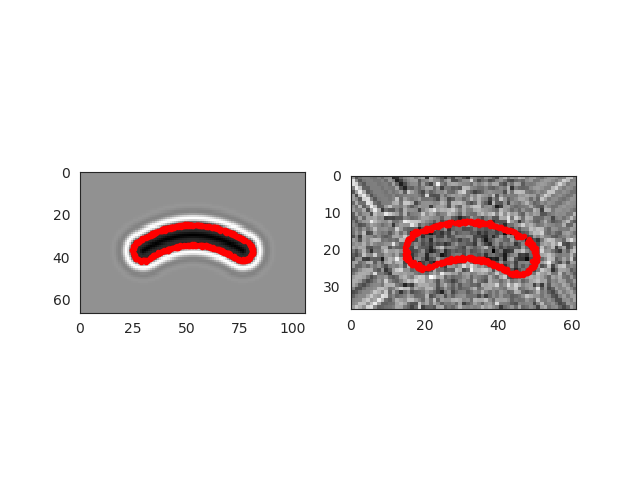

In [33]:
i = 1

fig, axes = plt.subplots(1, 2)
cp_gt = CellPlot(s_100_gt[i])
cp_m = CellPlot(s_100_m[i])
cp_gt.imshow('brightfield', ax=axes[0])
cp_gt.plot_storm(data_name='storm_inner', ax=axes[0])
cp_m.imshow('brightfield', ax=axes[1])
cp_m.plot_storm(data_name='storm_inner', ax=axes[1])

In [35]:
from sklearn.cluster import AffinityPropagation

X = np.array([[1, 2], [1, 4], [1, 0],[4, 2], [4, 4], [4, 0]])
clustering = AffinityPropagation().fit(X)
clustering 

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [36]:
clustering.labels_

array([0, 0, 0, 1, 1, 1])

In [37]:
storm_inner = np.load('storm_inner.npy')

In [275]:
st_f1 = storm_inner[storm_inner['frame'] == 2]

In [276]:
storm_inner['frame'].dtype

dtype('int64')

In [277]:
x, y = st_f1['x'], st_f1['y']

In [278]:
X = np.array([x,y]).T
X.shape

(4933, 2)

In [279]:
cluster = fc.linkage(X)

In [281]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(cluster, max_d, criterion='distance')
clusters



array([10, 10, 10, ...,  7,  7,  7], dtype=int32)

In [282]:
clustered_storm = [st_f1[clusters == i] for i in np.unique(clusters)]

<IPython.core.display.Javascript object>


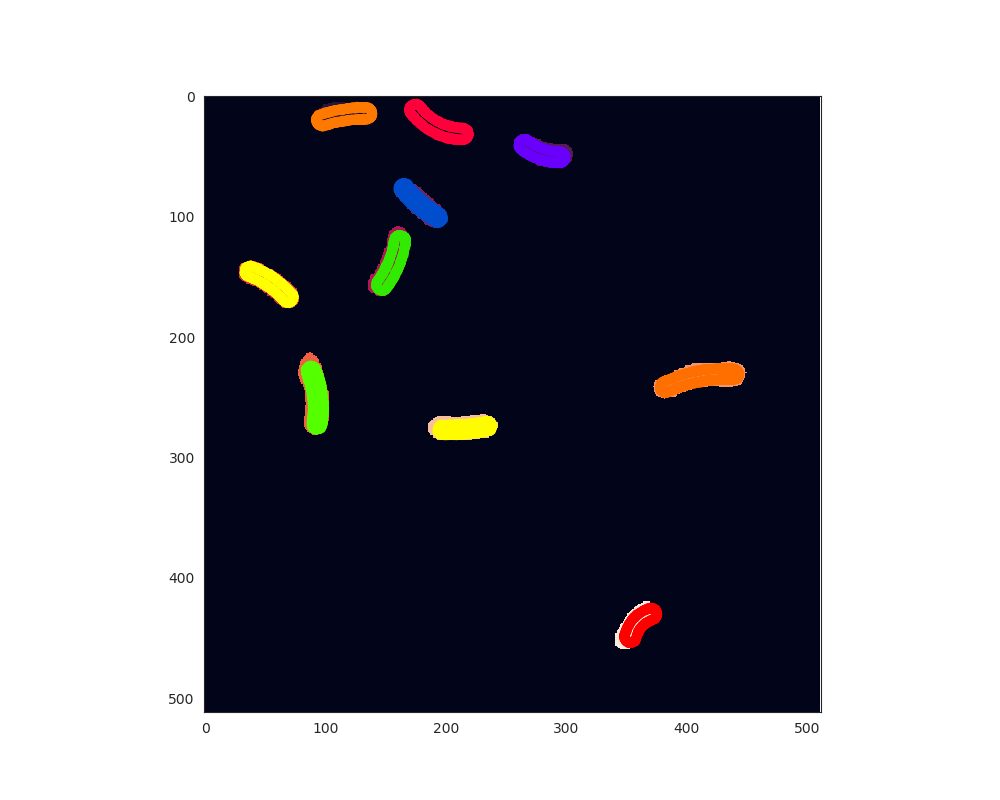

In [284]:
plt.figure(figsize=(10, 8))
plt.imshow(filtered_binary[1])
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

In [83]:
def encode(arr):
    encode_arr = (200 * np.arange(len(arr)) + 1) ** 2
    return np.sum(arr * encode_arr)

def encode_intensity(cells):
    out_arr = np.empty(len(cells), dtype=int)
    for i, cell in enumerate(cells):
        intensity = cell.data.data_dict['storm_inner']['intensity']
        out_arr[i] = encode(intensity)

    return out_arr

In [84]:
encoded_gt = encode_intensity(gt_cells[:9000])

In [85]:
encoded_gt[0]

494961152204958

In [285]:
encoded_storm = [encode(elem['intensity']) for elem in clustered_storm]

In [286]:
encoded_storm

[235885001302622,
 403748377526500,
 203051787421370,
 295732527459526,
 258572863300327,
 363755125062859,
 390518124519314,
 344752599599934,
 326967480424108,
 212384185141460]

In [ ]:
494961152204958

In [287]:
for _ in encoded_storm:
    print(np.argwhere(_ == encoded_gt))

[[14]]
[[17]]
[[18]]
[[15]]
[[22]]
[[19]]
[[23]]
[[21]]
[[16]]
[[13]]


In [288]:
s_cells = m_cells[img_numbers == 1]
len(s_cells)

9

In [102]:
orig_binary = tifffile.imread('binary_500photons_predicted.tif')
filtered_binary = filter_binaries(orig_binary, min_size=495, max_size=2006.4, min_minor=7.57, max_minor=17.3,
                                min_major=15.41, max_major=54.97)

In [244]:
binary = np.load('binary.npy')

In [251]:
bin_1000 = tifffile.imread('binary_1000photons_predicted.tif')


In [248]:
bf = tifffile.imread('bf_noise_500_photons.tif')

<IPython.core.display.Javascript object>


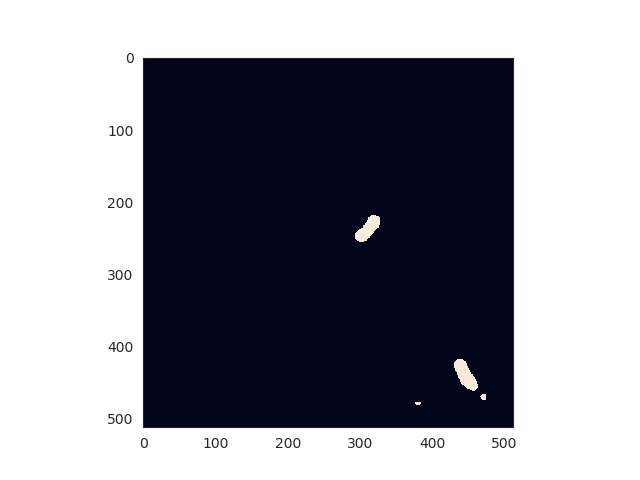

In [252]:
plt.figure()
plt.imshow(bin_1000[565])

<IPython.core.display.Javascript object>


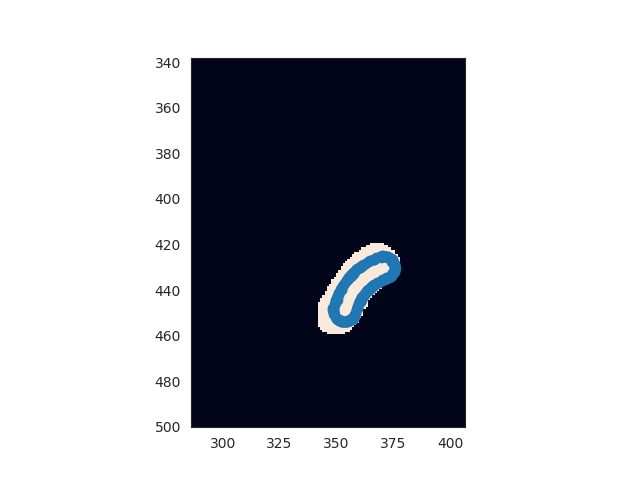

In [298]:
plt.figure()
plt.imshow(filtered_binary[1] == 9)
plt.scatter(clustered_storm[0]['x'], clustered_storm[0]['y'])
#plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism', alpha=0.1)  # plot points with cluster dependent colors

In [291]:
cell_numbers = np.array([int(re.findall(r'(\d+)', cell.name)[1]) for cell in s_cells])
cell_numbers

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [299]:
coms_cells = [mh.center_of_mass(filtered_binary[1]==i) for i in cell_numbers]
coms_cells

[array([ 14.79757785, 110.92387543]),
 array([ 45.93973214, 281.69754464]),
 array([ 89.36314068, 179.64994547]),
 array([137.91101322, 154.81674009]),
 array([155.20817121,  53.91439689]),
 array([247.68387097,  91.32419355]),
 array([233.99380165, 411.67837466]),
 array([275.02203065, 214.44061303]),
 array([439.06427689, 358.25710754])]

In [300]:
coms_storm = np.array([[np.mean(elem['y']), np.mean(elem['x'])] for elem in clustered_storm])
coms_storm

array([[438.71338336, 361.3363939 ],
       [234.04925758, 411.53391422],
       [275.576169  , 215.58543337],
       [139.16950652, 155.30579351],
       [ 89.04257185, 178.59850609],
       [ 46.63417176, 279.96237241],
       [ 23.3482593 , 193.79773223],
       [ 16.2899378 , 114.8650547 ],
       [155.32867342,  54.01490945],
       [251.20089559,  92.4883233 ]])

In [114]:
coms_storm[:, 1]

TypeError: list indices must be integers or slices, not tuple

In [301]:
coms_cells = np.array(coms_cells)

In [302]:
coms_cells

array([[ 14.79757785, 110.92387543],
       [ 45.93973214, 281.69754464],
       [ 89.36314068, 179.64994547],
       [137.91101322, 154.81674009],
       [155.20817121,  53.91439689],
       [247.68387097,  91.32419355],
       [233.99380165, 411.67837466],
       [275.02203065, 214.44061303],
       [439.06427689, 358.25710754]])

In [306]:
com_storm = coms_storm[0]
ds = np.sqrt((coms_cells[:, 0] - com_storm[0])**2 + (coms_cells[:, 1] - com_storm[1])**2)
ds
idx_m = np.argmin(ds)
idx_m, ds

(8, array([492.35255616, 400.76612556, 393.77094561, 364.87317426,
        418.19073347, 330.75498929, 210.81845783, 219.93914929,
          3.09921454]))

In [ ]:
8 3.0992145353155593
6 0.15473905961656698
7 1.271881649430098
3 1.350177264210859
2 1.0992220676779336
1 1.8689754063694235
2 67.51388326510406
0 4.2142653218760575
4 0.15691895813283951
5 3.704680857015749


In [1]:
for com_storm in coms_storm:
    ds = np.sqrt((coms_cells[:, 0] - com_storm[0])**2 + (coms_cells[:, 1] - com_storm[1])**2)
    ds
    idx_m = np.argmin(ds)
    print(idx_m, np.min(ds))

NameError: name 'coms_storm' is not defined

In [172]:
com_storm

array([401.2747831 , 343.15174928])

In [116]:
p = coms_cells[0]
ds = np.sqrt((p[0] - coms_storm[:, 0])**2 + (p[1] - coms_storm[:, 1])**2)
ds

array([414.79811931, 460.91641351, 235.4500514 , 165.77888013,
       249.65962717, 252.2035274 , 295.69431098,   1.03255486,
       114.46422437, 166.74710637])

In [118]:
match = np.argmin(ds)
match

7

<IPython.core.display.Javascript object>


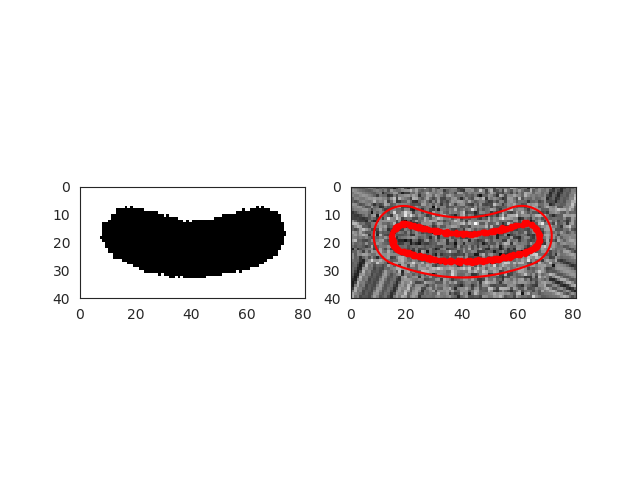

In [95]:
cp = IterCellPlot(s_cells)
fig, axes = iter_subplots(1, 2)
cp.imshow('binary', ax=axes[0])
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])
cp.plot_storm(data_name='storm_inner')
fig.display()

In [68]:
binary_gt = np.load('binary.npy')

In [69]:
binary_gt.shape

(1000, 512, 512)

In [70]:
c_max = 0
for b in binary_gt:
    c_max += len(np.unique(b)) - 1
c_max

8803

In [273]:
def match_cells(gt_cells, m_cells, storm_input, filtered_binaries, max_d=3): 
    img_numbers = np.array([int(re.findall(r'(\d+)', cell.name)[0]) for cell in m_cells])
    encoded_gt = encode_intensity(gt_cells[:9000])
    
    d_ = []
    
    gt_matched, m_matched = [], []
    for i in tqdm(np.unique(storm_input['frame'])[:10]):  # Iteration starts at 1 (ImageJ indexing)
        st_elem = storm_input[storm_input['frame'] == i].copy()
        X = np.array([st_elem['x'], st_elem['y']]).T.copy()
        linkage = fc.linkage(X)
        clusters = fcluster(linkage, max_d, criterion='distance')
        clustered_st = [st_elem[clusters == i] for i in np.unique(clusters)]
        encoded_storm = [encode(elem['intensity']) for elem in clustered_st]
        
        s_cells = m_cells[img_numbers == (i - 1)]
        if len(s_cells) == 0:
            print('No cells, img {}'.format(i))
            continue
            
        cell_numbers = np.array([int(re.findall(r'(\d+)', cell.name)[1]) for cell in s_cells])
        binary_img = filtered_binaries[i - 1]
        coms_cells = np.array([mh.center_of_mass(binary_img == j) for j in cell_numbers])
        
        bordering = 0
        too_far = 0
        for cluster, code in zip(clustered_storm, encoded_storm):
            
            # Find the GT cell
            idx_gt = np.argwhere(code == encoded_gt)
            if len(idx_gt) == 0:
                #print('Cluster not in cells, probably bordering cell')
                bordering += 1
                continue
            else:
                gt_cell = gt_cells[idx_gt[0][0]]
            
            
            # Find the M cell
            com_storm = [np.mean(cluster['y']), np.mean(cluster['x'])]
            ds = np.sqrt((coms_cells[:, 0] - com_storm[0])**2 + (coms_cells[:, 1] - com_storm[1])**2)
            print('ds', ds)
                       
            idx_m = np.argmin(ds)
            if np.min(ds) > 10:
                too_far += 1
                d_.append(np.min(ds))
                continue
            else:
                m_cell = s_cells[idx_m]
                
            gt_matched.append(gt_cell)
            m_matched.append(m_cell)
        if not bordering == too_far:
            print(bordering, too_far)
            print('Failure in index {}'.format(i))
            
        plt.figure()
        plt.imshow(binary_img)
        for c in clustered_st:
            plt.scatter(c['x'], c['y'])
            
    return gt_matched, m_matched, d_

ds [414.79811931 292.67128112 278.05532597 369.92261629 238.06321574
 190.83984442   1.12164945  46.25655417]
ds [460.91641351 324.29960959 319.93849828 417.50886097 272.60414548
 238.42425419  48.70397335   1.72136819]
ds [235.4500514  226.78801187 146.99527322 180.39888753 173.98142728
   1.35188834 188.5347652  235.90448122]
ds [165.77888013 106.09487579   1.96082587 194.82645531  83.9331408
 145.43416749 275.24303234 317.34131571]
ds [249.65962717  58.40629264  86.09974491 275.41181446   1.42588863
 175.46907537 236.81340096 271.53193447]
ds [252.2035274    1.61047023 106.36546811 300.58742733  57.57296648
 227.24509536 290.87054042 322.80477056]
ds [  1.03255486 250.82994945 164.24172011 114.1855431  247.87673003
 233.73559982 412.94517686 459.07526224]
ds [114.46422437 299.01755132 194.10370452   0.83818649 273.36410255
 178.87562808 368.52098556 415.87606768]
ds [166.74710637 358.94470497 253.44606434  60.87892596 330.06400303
 212.83556661 397.85608546 444.62625384]


<IPython.core.display.Javascript object>


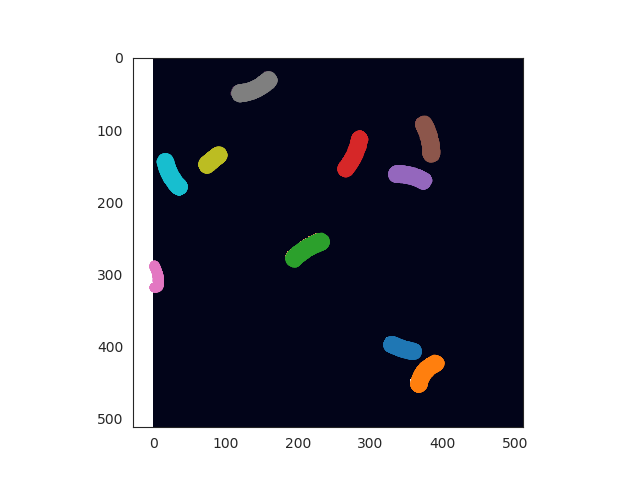

ds [450.88181995 360.61006323 352.1671656  323.77546382 379.74599867
 294.96997493 180.77285509 180.29507507  40.69665452]
ds [497.25575683 400.59998126 397.92565636 370.84496692 427.1742167
 341.3403552  204.18459503 227.8780279   18.74285825]
ds [269.08875575 228.96960767 177.74524516 138.62353472 192.1187796
 121.97636191 201.74777702  11.14716261 227.91773969]
ds [203.08263673  87.75435451 105.71115398 120.97494699 222.85728063
 216.88422416 169.08060315 154.22535863 316.52763053]
ds [286.44913312 139.25905404 190.96686107 202.26825587 301.59828099
 276.96762852  89.74049375 179.34928766 274.97112872]
ds [286.41380846 118.76488958 201.9174722  226.92096619 329.18400308
 319.14479053 125.7968988  232.41842096 327.62503269]
ds [308.18921543 378.97004366 277.21559433 224.217405   156.79419949
 103.80269945 413.5879491  212.3734977  379.15084627]
ds [ 38.25538074 143.45823171  63.23780808  97.80354635 141.5955568
 211.45862493 334.33696089 245.60878941 454.34177188]
ds [128.47485269 22

<IPython.core.display.Javascript object>


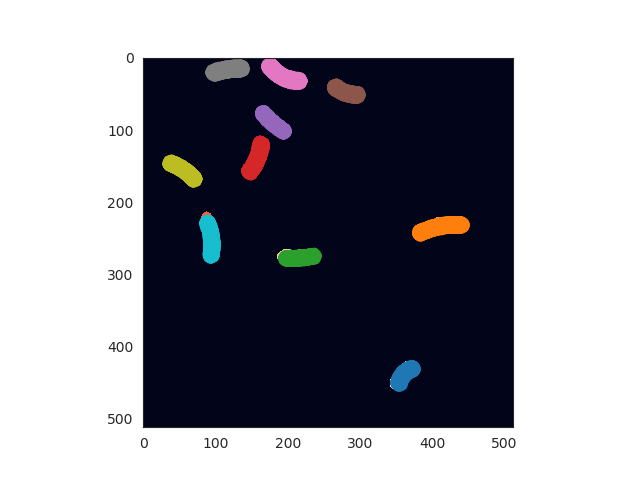

ds [334.26803614 240.10430327 303.7316025  208.63567524 342.31340075
 121.83731323 283.50066716 106.77622653  43.08025937 252.29677363]
ds [381.41833106 281.98579402 351.26196735 247.30542524 387.96880615
 144.45024054 321.01538195 135.31622743  54.86221594 280.3460888 ]
ds [148.17789409 121.36180508 114.41178618 132.00927701 173.10786667
 187.37525326 190.19352988 171.64674749 206.18246409 224.65813394]
ds [130.56703088  36.09671245 140.25530249  76.90838482 258.56108371
 200.02463748 326.37277058 301.74897619 308.68994363 369.57925211]
ds [212.67266933  69.19058604 214.13611699  43.20165191 324.0496977
 134.8259927  364.77774592 292.34537271 276.64644608 390.53958318]
ds [235.95169737 109.3013496  246.70508513  99.06506982 363.30870777
 180.84142425 416.37013389 349.88081474 331.72124794 446.22782704]
ds [222.40441389 313.26006362 188.97998138 338.22048941  72.62449018
 393.58535511  93.92517967 270.247525   345.23404832 179.23677578]
ds [ 90.70574487 194.68130864 132.68542829 239.80

<IPython.core.display.Javascript object>


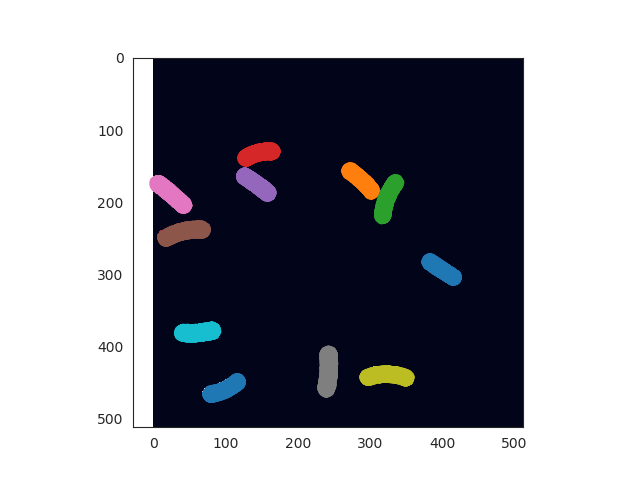

ds [261.47329778 115.56475528]
ds [286.71809257 161.25992104]
0 2
Failure in index 4


<IPython.core.display.Javascript object>


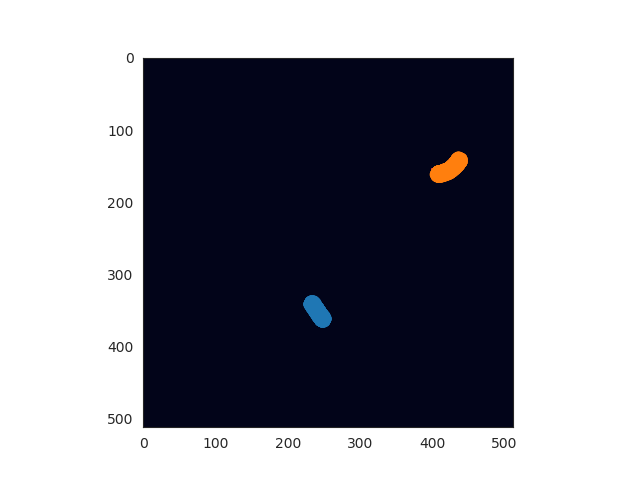

ds [428.96658613 296.95422991 350.4602552  235.9339893  208.38941155
 106.47776984  52.59449563  68.55880303 220.93027456]
ds [239.87635443 141.83618182 113.23734986 193.62094167  63.26809971
 219.43594009 215.71219968 286.10254671 179.06405988]
ds [110.99929288  25.5296286  148.68318508 136.41550852 207.20380444
 249.27985399 276.35305919 341.79520394 323.61309184]
ds [175.83201369  61.50400802 221.12169719  53.29921442 225.03962597
 184.66881847 223.36149415 280.98684128 335.76299056]
ds [159.39501136  92.45334702 254.89924713  88.93949451 280.27576452
 228.59743078 272.62845906 324.75830477 392.46334065]
ds [367.86853938 329.98777844 179.30327752 404.41342519 196.28243925
 416.32286978 395.41220363 458.75332277 199.82396847]
ds [108.52704019 190.79842997 139.84776125 301.51566077 290.90019232
 407.89770086 426.16547125 495.28174217 392.88245821]
ds [199.38064592 214.10553507  67.38586183 318.7968008  219.96479141
 390.84020951 394.41804275 465.10597281 303.23310198]
ds [259.71399402

<IPython.core.display.Javascript object>


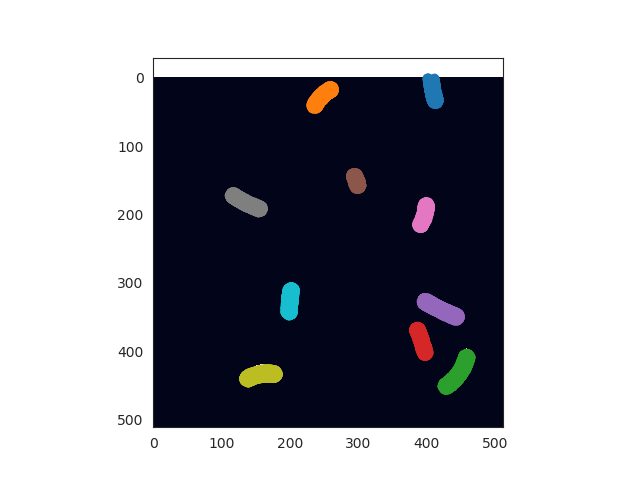

ds [333.0448593  299.92370497 220.69261637 302.36281116 142.58957767
 220.7713369  107.62274027]
ds [365.03489431 343.77707575 267.27195169 348.91172393 174.50553961
 261.606457    68.46414827]
ds [255.51784003 147.21584234  53.02889022 126.656049   155.74961033
 126.57868383 289.38388157]
ds [120.74970408  38.1448681   93.2762877  215.2553777  157.22806533
 269.01650103 346.61285329]
ds [ 96.79699058 123.49582179 137.04754703 277.60164584  97.54952102
 299.4497486  286.22264525]
ds [ 42.10767292 140.27539645 183.24216762 318.52821168 149.18406037
 352.78057069 330.15993887]
ds [441.42364152 299.55092182 241.0860389  106.17592616 366.40480376
 133.94309155 460.36088042]
0 7
Failure in index 6


<IPython.core.display.Javascript object>


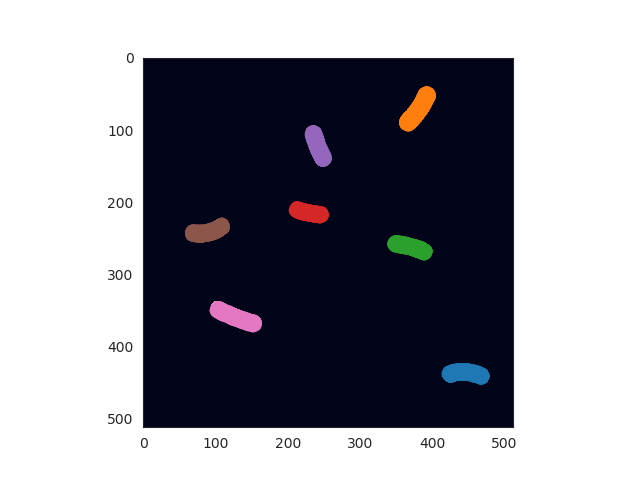

ds [428.7836955  355.96453082 238.13895453 193.18820764 115.0706394 ]
ds [474.19927307 394.42114643 268.36062961 231.884443   130.35278061]
ds [254.12941406 235.19095292 198.67147441 126.448755   206.30895767]
ds [169.23111072  90.47144397 114.74185464  90.56521816 223.86317776]
ds [250.2297038  127.51245853  30.22309101  53.56942977 157.03706711]
0 5
Failure in index 7


<IPython.core.display.Javascript object>


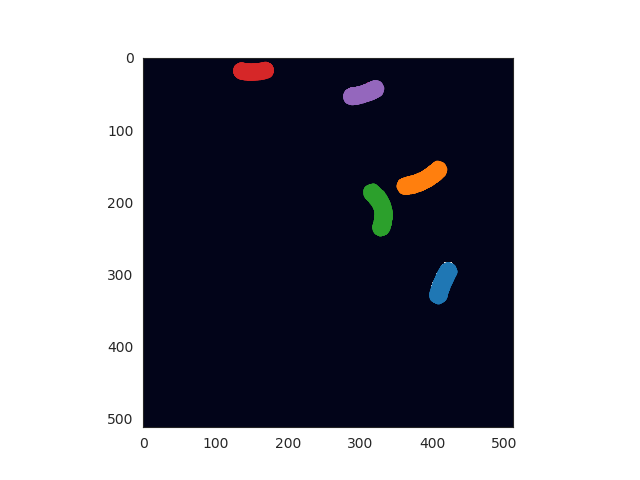

ds [387.26990687 295.22357738 257.47321265 310.09338117 361.99152744
 125.81869482 318.55051299  68.60306487 317.19956448 210.58608468]
ds [431.50343756 336.21811656 292.63841324 357.6514942  408.26672391
 143.51798773 362.18897882  66.6366901  346.66461231 237.45594476]
ds [222.93053293 167.29289153 181.73802054 120.55451749 185.92390448
 202.59526483 170.15691737 224.39954915 263.27136443 206.23372581]
ds [119.26124163  22.23820292  73.4827658  147.15055548 255.97569168
 212.34220933 280.13653855 275.4839957  404.04972802 351.08330484]
ds [198.08627532  89.34465836  21.40240126 221.71580836 326.3698299
 143.73717487 336.13824683 217.82206787 435.83793801 363.7431379 ]
ds [193.82760619  97.70751853  44.89559468 253.72336321 362.1305152
 186.69844947 380.78871515 264.92072634 489.5062901  420.47023867]
ds [327.32177079 338.02558858 379.77451765 184.66528474  93.74335113
 408.27918227  42.11218657 409.17050971 153.04267883 205.16958546]
ds [ 61.47760509 160.70678938 233.74779203 131.061

<IPython.core.display.Javascript object>


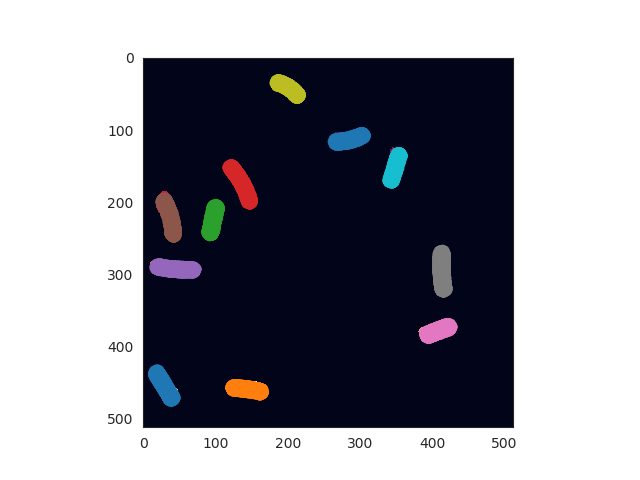

ds [284.58092962 235.26562371 222.18182667 187.64815127 132.35188418
 298.1383786  269.4106877   98.86798062 282.80789148]
ds [328.29732768 278.15453539 249.30229881 204.29509189 164.02535684
 342.52790789 309.81464982  72.04783316 312.48328213]
ds [135.83090695 109.06356239 205.37972887 230.32017183 156.23520835
 145.90225474 159.01718496 269.4453414  236.7504602 ]
ds [297.79292621 300.75006056 415.31475076 441.79216693 365.67459476
  66.30075511  87.87378675 449.41578333 157.26579365]
ds [142.87892651 192.4024539  301.81359842 363.0586022  325.10361159
 254.83214109 314.56377952 473.51445277 414.20425507]
ds [166.36966524 197.65266471 324.33274749 373.66978645 315.19614166
 147.1800836  210.46045951 447.13248799 309.63780414]
ds [225.77292809 252.47512777 379.43148312 424.8640838  361.21915985
 132.19493998 196.30265982 483.45169103 290.10804888]
3 7
Failure in index 9


<IPython.core.display.Javascript object>


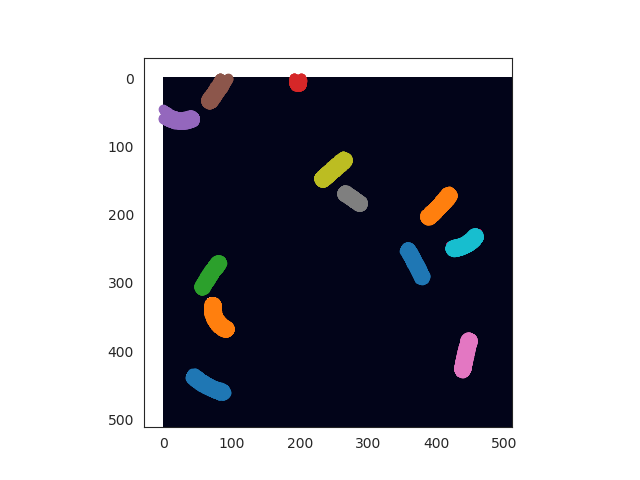

ds [337.90061051 417.39336705 123.04845122 161.40157651]
ds [366.04198227 464.96619446 162.43221483 193.24549494]
ds [280.06146576 228.06891838 121.77477899 163.91722326]
ds [152.75712193 234.53858896 156.07993981 306.20482118]
ds [110.53298412 317.51896905 116.67810643 312.80089231]
2 5
Failure in index 10


<IPython.core.display.Javascript object>


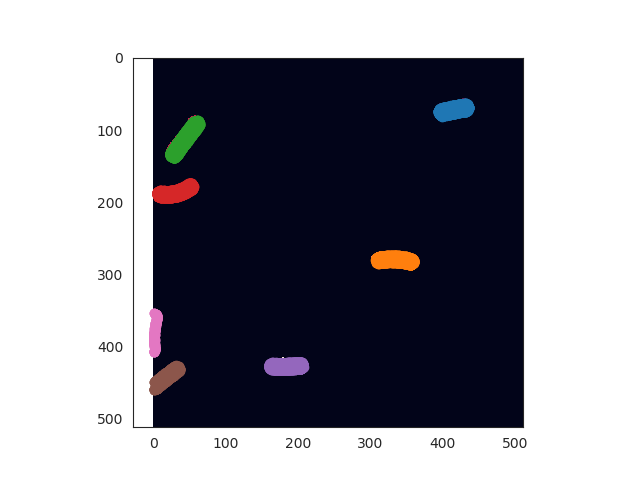

In [274]:
gt, m, dist = match_cells(gt_cells[:9000], m_cells, storm_inner, filtered_binary, max_d=5)

In [224]:
len(gt)

8

<IPython.core.display.Javascript object>


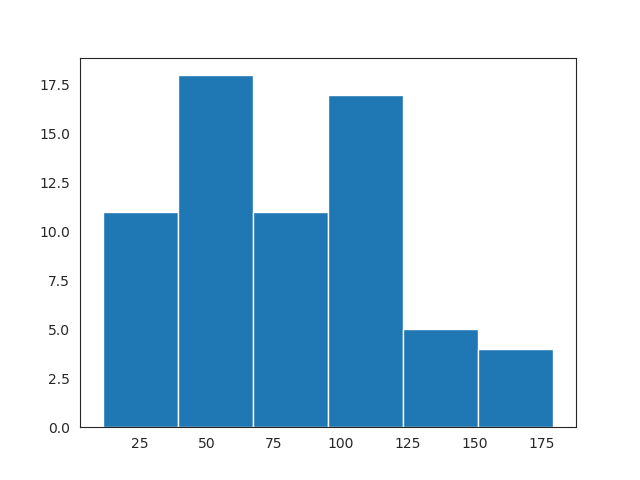

(array([11., 18., 11., 17.,  5.,  4.]),
 array([ 11.14716261,  39.17318176,  67.19920091,  95.22522007,
        123.25123922, 151.27725837, 179.30327752]),
 <a list of 6 Patch objects>)

In [266]:
plt.figure()
plt.hist(dist, bins='fd')

In [192]:
gt


<IPython.core.display.Javascript object>


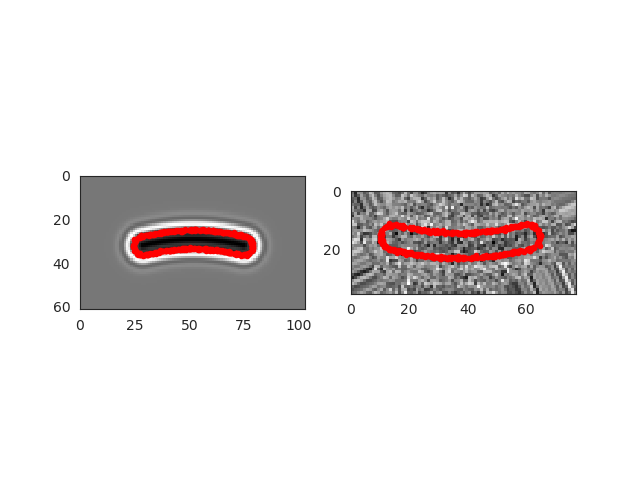

In [229]:
i = 3

fig, axes = plt.subplots(1, 2)
cp_gt = CellPlot(gt[i])
cp_m = CellPlot(m[i])
cp_gt.imshow('brightfield', ax=axes[0])
cp_gt.plot_storm(data_name='storm_inner', ax=axes[0])
cp_m.imshow('brightfield', ax=axes[1])
cp_m.plot_storm(data_name='storm_inner', ax=axes[1])

In [230]:
len(m[i].data.data_dict['storm_inner']), len(gt[i].data.data_dict['storm_inner'])

(547, 547)

In [232]:
m[i].optimize('storm_inner')

<IPython.core.display.Javascript object>


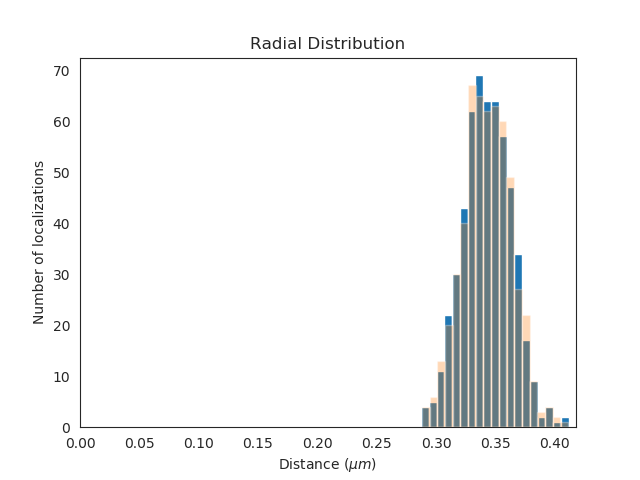

(array([ 4.,  6., 13., 20., 30., 40., 67., 65., 62., 63., 60., 49., 27.,
        22.,  9.,  3.,  4.,  2.,  1.]),
 array([0.28813344, 0.29460312, 0.30107279, 0.30754246, 0.31401214,
        0.32048181, 0.32695148, 0.33342116, 0.33989083, 0.3463605 ,
        0.35283018, 0.35929985, 0.36576953, 0.3722392 , 0.37870887,
        0.38517855, 0.39164822, 0.39811789, 0.40458757, 0.41105724]),
 <a list of 19 Patch objects>)

In [236]:
plt.figure()
cp_m.hist_r_storm(norm_x=False)
cp_gt.hist_r_storm(norm_x=False, alpha=0.3)